In [55]:
import pandas as pd
import numpy as np
import json

# 데이터 로드
try:
    # [수정] Google Canvas 환경에서 파일 이름으로 바로 접근하도록 경로를 수정합니다.
    df = pd.read_csv('notebooks/anilist_top10000_eda.csv')
    print("데이터 로드 성공.")
except FileNotFoundError:
    print("오류: anilist_top10000_eda.csv 파일을 찾을 수 없습니다.")
    # 오류 발생 시 프로그램 종료 (EDA 진행 불가)
    exit()

# ----------------------------------------------------
# 불필요한 컬럼 제거 (Feature Selection)
# ----------------------------------------------------

# EDA 및 모델링을 위해 핵심적인 정보만 남기고 불필요하거나 중복되는 컬럼을 제거합니다.
# 원본 데이터는 247개 이상의 컬럼(개별 태그 및 장르 OHE 포함)을 가집니다.

# 유지할 핵심 컬럼 목록
keep_cols = [
    'id', 'format', 'status', 'start_year', 'episodes', 'duration', 
    'averageScore', 'popularity', 'favourites', 'genres', 'studios_list',
    'title_romaji', 'title_english', 'title_native'
]

# [변경] 제거할 컬럼 확인 및 제거
# 'start_month', 'start_day' 등 상세 날짜 정보, 'airing_days', 'season' 등 중복되거나 파생 가능한 정보
# 'tag_list', 'stats', 'meanScore'(averageScore와 중복) 그리고 모든 OHE 장르/태그 컬럼을 제거합니다.
columns_to_drop = [col for col in df.columns if col not in keep_cols]
df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')

print(f"\n[컬럼 제거 결과]")
print(f"원본 컬럼 수: {len(df.columns)}")
print(f"제거된 컬럼 수: {len(columns_to_drop)}")
print(f"최종 컬럼 수: {len(df_cleaned.columns)}")
print(f"남은 컬럼 목록: {df_cleaned.columns.tolist()}")

# df_cleaned를 사용하여 EDA 계속 진행
df = df_cleaned

# ===============================================
# 데이터 기본 정보 확인 (업데이트됨)
# ===============================================

total_rows = len(df)
total_cols = len(df.columns)
print(f"\n[2. 데이터 기본 정보 확인]")
print(f"총 행 수 (Total Rows): {total_rows}")
print(f"총 열 수 (Total Columns): {total_cols}")
print(f"주요 컬럼: {df.columns.tolist()}")

# ===============================================
# 기술 통계 및 데이터 요약
# ===============================================

# 주요 수치형 변수: averageScore, popularity, episodes, duration, favourites
numeric_cols = ['averageScore', 'popularity', 'episodes', 'duration', 'favourites']
# favourites 컬럼이 포함되어 기술 통계가 업데이트되었습니다.
numeric_summary = df[numeric_cols].describe().T[['mean', '50%', 'std', 'min', 'max']].round(2)
numeric_summary.rename(columns={'50%': 'median', 'std': 'std_dev'}, inplace=True)

print("\n[3. 기술 통계 요약 - 수치형 변수]")
print(numeric_summary.to_markdown())

# 주요 범주형 변수: format (형식), status (방영/출시 상태)
format_counts = df['format'].value_counts(normalize=True).mul(100).round(1)
status_counts = df['status'].value_counts(normalize=True).mul(100).round(1)

print("\n[3. 기술 통계 요약 - 범주형 변수]")
print(f"Format Counts:\n{format_counts.to_markdown()}")
print(f"\nStatus Counts:\n{status_counts.to_markdown()}")

# ===============================================
# 결측치 및 이상치 탐색
# ===============================================

missing_values = df[numeric_cols].isnull().sum()
missing_report = missing_values[missing_values > 0]

print("\n[4. 결측치 보고]")
if missing_report.empty:
    print("주요 수치형 변수에서 결측치가 발견되지 않았습니다.")
else:
    print(missing_report.to_markdown())

# 이상치 탐색 (popularity 상위 5개)
top_popularity = df.sort_values(by='popularity', ascending=False)[['title_romaji', 'popularity', 'averageScore']].head(5)
print("\n[4. 이상치 탐색 - Popularity (인기) 상위 5]")
print(top_popularity.to_markdown(index=False))

# ===============================================
# 변수 간 관계 분석
# ===============================================

# Format 별 averageScore 평균
format_score_mean = df.groupby('format')['averageScore'].mean().sort_values(ascending=False).round(2)
print("\n[5.1 형식(Format)별 평균 점수]")
print(format_score_mean.to_markdown())

# Popularity와 Score의 상관관계
# 'favourites' 컬럼을 포함하여 상관관계 계산
correlation_cols = ['averageScore', 'popularity', 'episodes', 'favourites']
correlation = df[correlation_cols].corr().round(2)
print(f"\n[5.2 상관관계]")
print(correlation.to_markdown())

# 장르 탐색 (가장 빈번한 장르 Top 5)
# [변경] genres 컬럼에서 장르 목록을 추출하고 빈도수를 계산합니다.
all_genres = df['genres'].str.strip('[]').str.replace("'", "").str.split(', ').explode().str.strip()
top_genres = all_genres.value_counts().head(5)

print("\n[5.3 가장 빈번한 장르 Top 5]")
print(top_genres.to_markdown())

# ===============================================
# 6. 파생 변수 생성 및 전처리 제안
# ===============================================

# start_year 기준으로 시대 구분
def categorize_year(year):
    if pd.isna(year):
        return 'Unknown'
    # year 값이 float일 수 있으므로 int로 변환 (결측치 처리 후 int 변환 시도)
    try:
        year = int(year)
    except ValueError:
        return 'Unknown'
        
    if year < 1990:
        return 'Classic'
    elif year < 2010:
        return '00s'
    elif year < 2020:
        return '10s'
    else:
        return '20s'

df['era'] = df['start_year'].apply(categorize_year)
era_distribution = df['era'].value_counts(normalize=True).mul(100).round(1)

print("\n[6. 파생 변수 - 시대별 분포]")
print(era_distribution.to_markdown())

데이터 로드 성공.

[컬럼 제거 결과]
원본 컬럼 수: 247
제거된 컬럼 수: 233
최종 컬럼 수: 14
남은 컬럼 목록: ['id', 'format', 'status', 'start_year', 'episodes', 'duration', 'averageScore', 'popularity', 'favourites', 'genres', 'title_romaji', 'title_english', 'title_native', 'studios_list']

[2. 데이터 기본 정보 확인]
총 행 수 (Total Rows): 10000
총 열 수 (Total Columns): 14
주요 컬럼: ['id', 'format', 'status', 'start_year', 'episodes', 'duration', 'averageScore', 'popularity', 'favourites', 'genres', 'title_romaji', 'title_english', 'title_native', 'studios_list']

[3. 기술 통계 요약 - 수치형 변수]
|              |     mean |   median |   std_dev |   min |    max |
|:-------------|---------:|---------:|----------:|------:|-------:|
| averageScore |    64.9  |     65   |      9.55 |    16 |     91 |
| popularity   | 26284.3  |   5596.5 |  62305.9  |   741 | 923138 |
| episodes     |    13.42 |     10   |     31.84 |     1 |   1787 |
| duration     |    30.68 |     24   |     27.41 |     1 |    168 |
| favourites   |   637.05 |     48   |   2748.1  |

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm


# 한글폰트 사용을 위한 설정(Window)
import matplotlib
import matplotlib.font_manager as fm

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
# matplotlib.rc 또는 plt.rc 모두 가능
matplotlib.rc('font', family=font_name)

# 데이터 로드
file_path = 'anilist_top10000_eda.csv'
df = pd.read_csv('notebooks/anilist_top10000_eda.csv')

print("--- 1. 데이터 기본 정보 ---")
print(f"데이터셋 크기: {df.shape[0]} 행, {df.shape[1]} 열")
df.head() # 데이터 상위 5개 행 출력

# df.columns.tolist()

--- 1. 데이터 기본 정보 ---
데이터셋 크기: 10000 행, 247 열


,id,format,status,start_year,start_month,start_day,end_year,end_month,end_day,airing_days,...,tag_Video Games,tag_Virtual World,tag_War,tag_Witch,tag_Work,tag_Yakuza,tag_Yandere,tag_Youkai,tag_Yuri,tag_Zombie
0,16498,TV,FINISHED,2013.0,4.0,7.0,2013.0,9.0,28.0,174.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101922,TV,FINISHED,2019.0,4.0,6.0,2019.0,9.0,28.0,175.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1535,TV,FINISHED,2006.0,10.0,4.0,2007.0,6.0,27.0,266.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,113415,TV,FINISHED,2020.0,10.0,3.0,2021.0,3.0,27.0,175.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,21459,TV,FINISHED,2016.0,4.0,3.0,2016.0,6.0,26.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
## 결측치 비율 확인
print("\n--- 2-1. 컬럼별 결측치 비율 ---")
missing_ratio = df.isnull().sum() / len(df) * 100
missing_df = pd.DataFrame({'Missing Ratio': missing_ratio})
print(missing_df[missing_df['Missing Ratio'] > 0].sort_values(by='Missing Ratio', ascending=False))

## 2-2. 핵심 변수 결측치 처리 (점수 기준 분석을 위해 결측치 행 제거)
# averageScore와 meanScore는 분석의 핵심이므로 결측치를 가진 행을 제거합니다.
df_clean = df.dropna(subset=['averageScore', 'meanScore']).copy()
print(f"\n결측치 제거 후 데이터셋 크기: {df_clean.shape[0]} 행")


--- 2-1. 컬럼별 결측치 비율 ---
                     Missing Ratio
title_english                31.63
seasonYear                    8.72
season                        8.72
airing_days                   5.04
end_day                       4.75
...                            ...
genre_Slice of Life           0.92
genre_Adventure               0.92
genre_Action                  0.92
genre_Horror                  0.92
title_native                  0.53

[233 rows x 1 columns]

결측치 제거 후 데이터셋 크기: 9676 행


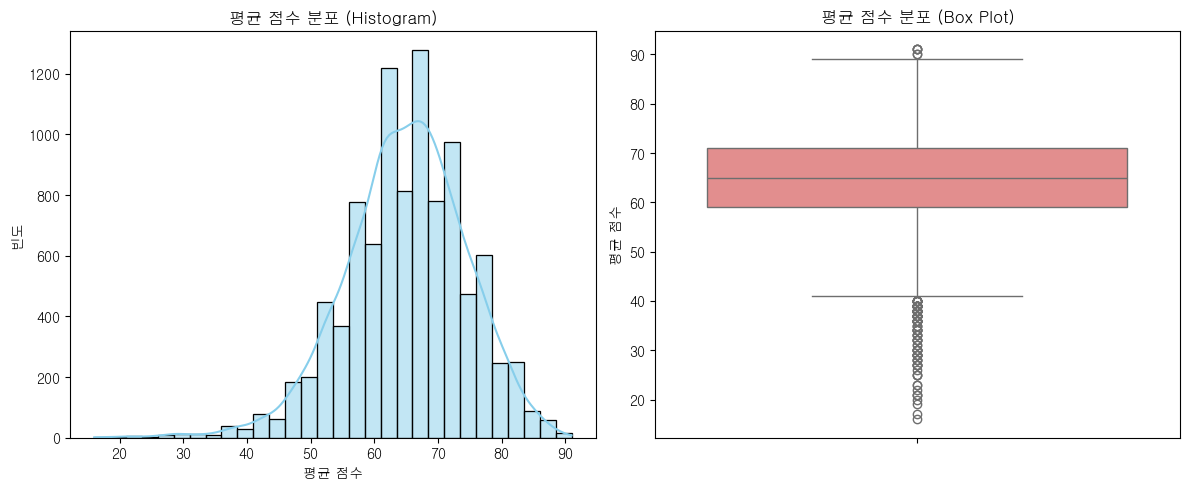

In [58]:
## 평균 점수 (averageScore) 분포 분석 및 시각화
plt.figure(figsize=(12, 5))

# 히스토그램: 점수의 일반적인 분포 확인
plt.subplot(1, 2, 1)
sns.histplot(df_clean['averageScore'], kde=True, bins=30, color='skyblue')
plt.title('평균 점수 분포 (Histogram)')
plt.xlabel('평균 점수')
plt.ylabel('빈도')

# 상자 그림: 이상치 및 사분위수 확인
plt.subplot(1, 2, 2)
sns.boxplot(y=df_clean['averageScore'], color='lightcoral')
plt.title('평균 점수 분포 (Box Plot)') 

# [Image of a box plot]

plt.ylabel('평균 점수')

plt.tight_layout()
plt.show()

## 1. 평균 점수 분포 (Histogram)
- 데이터 분석 결과 
    1) 50~80점 사이에 가장 많은 분포도 보임 
    2) 60~75점 구간에 빈도가 높아 정규분포 형태에 가까운 패턴
    3) 평균적인 점수대에 고르게 분포하고 있음 
    4) 40점 이하의 작품은 상대적으로 적으며, 저평가된 애니메이션은 소수로 확인

## 2. 평균 점수 분포 (Box Plot)
- 데이터 분석 결과 
    1) 애니메이션 전반적으로 평균 약 68점 이상의 평가 받음 
    2) 40점 이하의 이상치가 확인 되며, 혹평을 받고 있는 소수의 애니메이션도 확인 됨
    3) 전체적으로 평균 점수는 크게 왜곡 되지 않았으며, 일정한 범위 내에서 안정적인 분포 보임 

짧게 요약 하면 히스토그램은 평균 점수 60~75점 구간 집중 정규분포 형태 보임 
박스플롯은 중앙값 68점, 하단에 소수의 저평가 애니메이션 이상치 나타남 
전체적으로 평균 점수는 안정적이고 극단적인 값은 많지 않음 


[5. 변수 간 관계 분석 및 시각화]


C:\Users\cjh98\AppData\Local\Temp\ipykernel_8616\3900724856.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=format_score_mean.index, y=format_score_mean.values, palette='viridis')


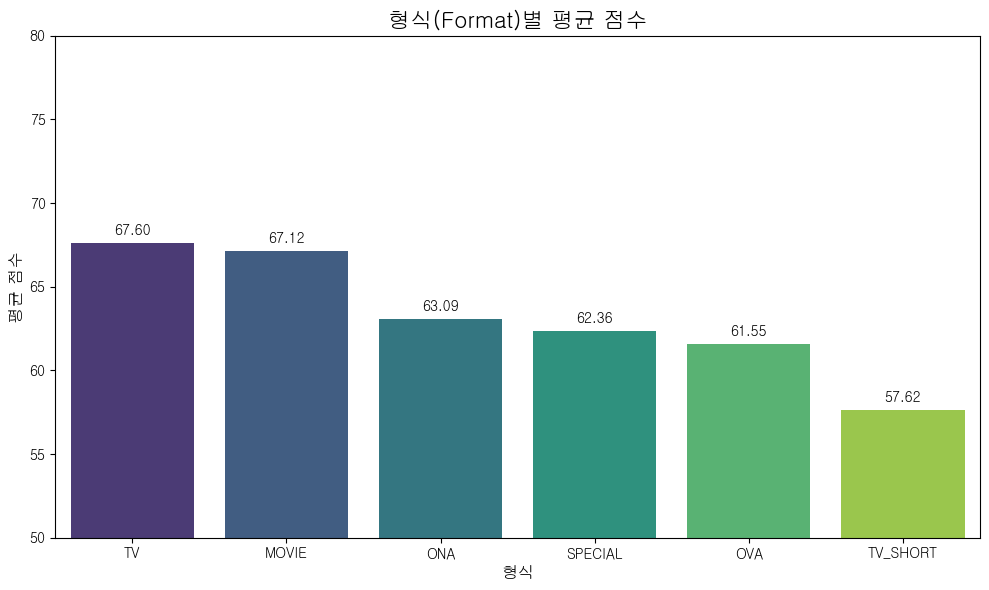

In [59]:
# ===============================================
# 변수 간 관계 분석 및 시각화 (개선)
# ===============================================

print("\n[5. 변수 간 관계 분석 및 시각화]")

# Format (형식)별 평균 점수 시각화
plt.figure(figsize=(10, 6))
# 'viridis' 색상 팔레트를 사용하여 색감을 개선하고, 막대 색상을 구분
format_score_mean = df.groupby('format')['averageScore'].mean().sort_values(ascending=False)
ax = sns.barplot(x=format_score_mean.index, y=format_score_mean.values, palette='viridis')
plt.title('형식(Format)별 평균 점수', fontsize=16)
plt.xlabel('형식', fontsize=12)
plt.ylabel('평균 점수', fontsize=12)
plt.ylim(50, 80) # 점수 범위 조정

# 막대 끝에 수치 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)
plt.tight_layout()
plt.show()

## 1. 애니메이션 형태별 작품 개수 분포
- 데이터 분석 결과
    1) TV애니메이션이 총 3,858편으로 압도적으로 높은 비중 차지
       (많은 사람들이 쉽게 접할 수 있는 플랫폼 형태에 집중 됨)
    2) 다음으로는 OVA가 약 1,612편 / MOVIE가 1,513편으로 나타나고 있으며, 
       TV 다음으로 비교적 높은 제작량 보임
    3) 최근 플랫폼 환경에 변화에 따라 ONA(온라인 애니메이션)의 제작량이 증가하고 있는 것으로 확인 됨


--- 4-1. 점수와 인기도의 상관관계 ---
              averageScore  popularity  favourites
averageScore      1.000000    0.399426    0.329467
popularity        0.399426    1.000000    0.855526
favourites        0.329467    0.855526    1.000000


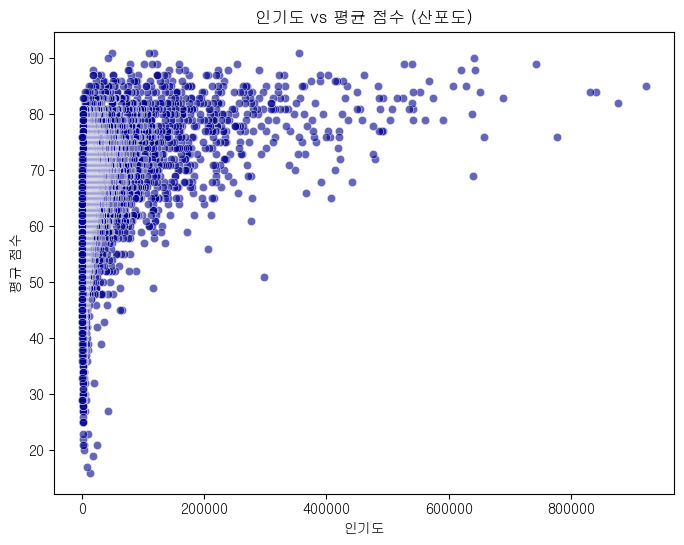

In [60]:
## 점수 vs 인기도 관계 (Correlation Analysis)
print("\n--- 4-1. 점수와 인기도의 상관관계 ---")
correlation = df_clean[['averageScore', 'popularity', 'favourites']].corr()
print(correlation)

# 산점도를 통한 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x='popularity', y='averageScore', data=df_clean, alpha=0.6, color='darkblue') 

# [Image of a scatter plot]

plt.title('인기도 vs 평균 점수 (산포도)')
plt.xlabel('인기도')
plt.ylabel('평규 점수')
plt.show()

# 인기도 변수가 매우 치우쳐 있으므로, 인기도를 기준으로 상위 1000개만 뽑아 다시 시각화해보는 것도 좋습니다.


--- 4-2. 장르별 평균 점수 (Top 10) ---
             genres  Average Score
20  'Psychological'      70.977716
26  'Slice of Life'      70.784091
63        ['Sports'      70.428571
18        'Mystery'      69.543967
4           'Drama'      69.523179
30   'Supernatural'      69.421053
32      'Thriller']      69.385417
16          'Music'      69.211382
19       'Mystery']      68.407609
28         'Sports'      68.066667


C:\Users\cjh98\AppData\Local\Temp\ipykernel_8616\2626846664.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average Score', y='genres', data=genre_score_df.head(10), palette='rocket')


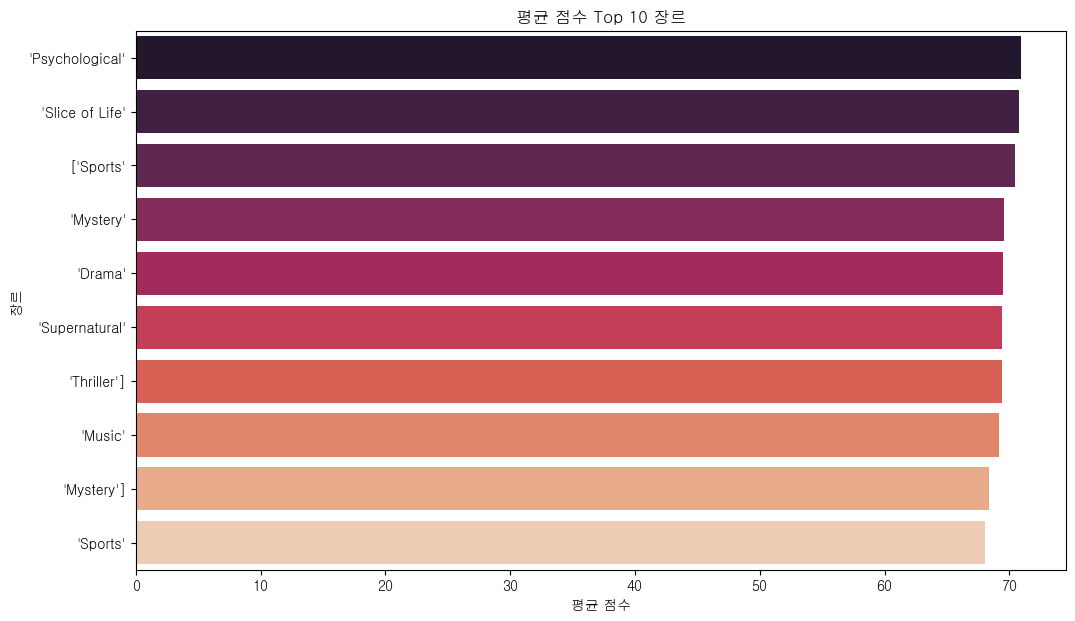

In [61]:
## 장르별 평균 점수 분석
# 장르 컬럼(genres)을 쉼표로 분리하여 모든 장르를 리스트로 만듭니다.
all_genres = df_clean['genres'].str.split(', ').explode().str.strip()
all_genres = all_genres.dropna()

# 각 장르별 평균 점수를 계산하는 함수 (장르가 여러개인 애니를 그룹핑하기 위해)
def get_genre_scores(genre):
    # 해당 장르를 포함하는 모든 애니메이션을 필터링
    df_genre = df_clean[df_clean['genres'].str.contains(genre, na=False)]
    return df_genre['averageScore'].mean()

# 고유 장르 리스트를 얻고, 각 장르별 평균 점수를 계산합니다.
# genres 컬럼이 문자열일 수 있으므로 안전하게 리스트로 변환
df_clean['genres'] = df_clean['genres'].fillna('').apply(lambda x: x.split(', ') if isinstance(x, str) else x)

# 장르별로 한 줄씩 펼치기 (explode)
df_genre_exploded = df_clean.explode('genres')

# 공백 장르 제거
df_genre_exploded = df_genre_exploded[df_genre_exploded['genres'] != '']

# 장르별 평균 점수 계산
genre_score_df = (
    df_genre_exploded.groupby('genres')['averageScore']
    .mean()
    .reset_index(name='Average Score')
    .sort_values(by='Average Score', ascending=False)
)

genre_score_df

# 평균 점수 기준으로 정렬
genre_score_df = genre_score_df.sort_values(by='Average Score', ascending=False)

print("\n--- 4-2. 장르별 평균 점수 (Top 10) ---")
print(genre_score_df.head(10))


# 시각화 (Top 10 장르)
plt.figure(figsize=(12, 7))
sns.barplot(x='Average Score', y='genres', data=genre_score_df.head(10), palette='rocket')
plt.title('평균 점수 Top 10 장르')
plt.xlabel('평균 점수')
plt.ylabel('장르')
plt.show()




## 1. 평균 점수 Top 장르 분석
- 데이터 분석 결과 
    1) 장르 중에서는 Psychological(심리)에서 가장 높은 평균 점수 기록 
    2) 뒤를 이어 Slice of Life, Sports, Mystery, Drama, Supernatural 등의 장르가 높은 평가를 받음 
    3) 장르 전반적으로 약 70점대에 근접한 평가를 받고 있으며, 장르별로 편차는 크지 않으나
       서사 중심 장르(Drama, Mystery, Psychological)가 액션/코미디 장르보다 높은 평가를 받는 것으로 확인 됨
    4) 시각적인 요소 보다는 스토리, 연출, 작품성 등이 시청자의 점수에 반영 되는 것으로 해석 됨 

In [62]:
# 상관 계수 계산
correlation = df_clean['averageScore'].corr(df_clean['popularity'])

print("--- 평균 점수 vs 인기도 상관 계수 ---")
print(f"상관 계수 (Correlation Coefficient, r): {correlation:.4f}")

--- 평균 점수 vs 인기도 상관 계수 ---
상관 계수 (Correlation Coefficient, r): 0.3994



--- 평균 점수 vs Log(인기도) 상관 계수 ---
Log 변환 후 상관 계수: 0.3994


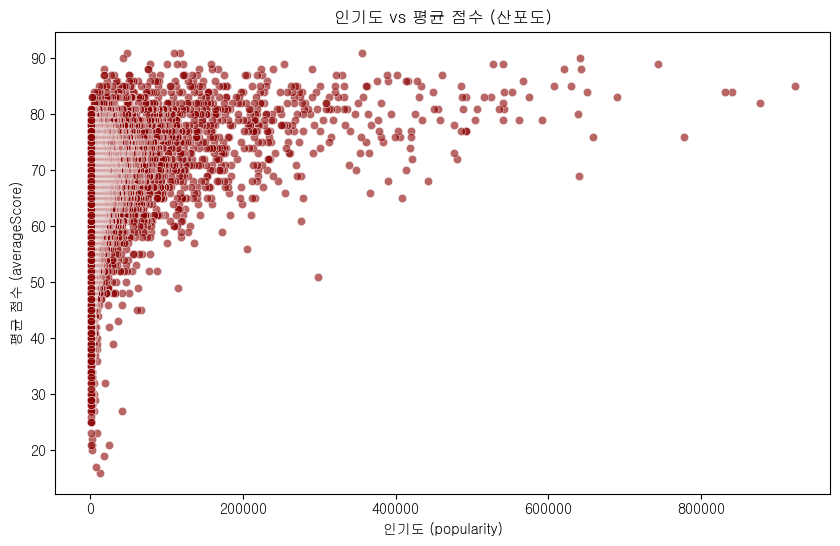

In [63]:
## 산점도 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='popularity', y='averageScore', data=df_clean, alpha=0.6, color='darkred')

log_correlation = df_clean['averageScore'].corr(df_clean['popularity'])

print("\n--- 평균 점수 vs Log(인기도) 상관 계수 ---")
print(f"Log 변환 후 상관 계수: {log_correlation:.4f}")

plt.title('인기도 vs 평균 점수 (산포도)')
plt.xlabel('인기도 (popularity)')
plt.ylabel('평균 점수 (averageScore)')
plt.show()

## 1. 평균 점수 vs 인기도 (원본값 산포도)
- 데이터 분석 결과 
    1) 대부분 데이터가 인기도가 낮은 영역 (0~5만사이)에 밀집, 이는 인기도 분포 자체가 극단적으로 
       심한 비대칭구조를 가지고 있음을 보여줌
       해당 plot 으로 구체적인 패턴을 시각적으로 파악하기 어려워 Log 변환을 통해 범위를 압축하여 분포를 펼쳐줌으로써 
       상관관계를 더 잘 보기 위해 작업 진행 

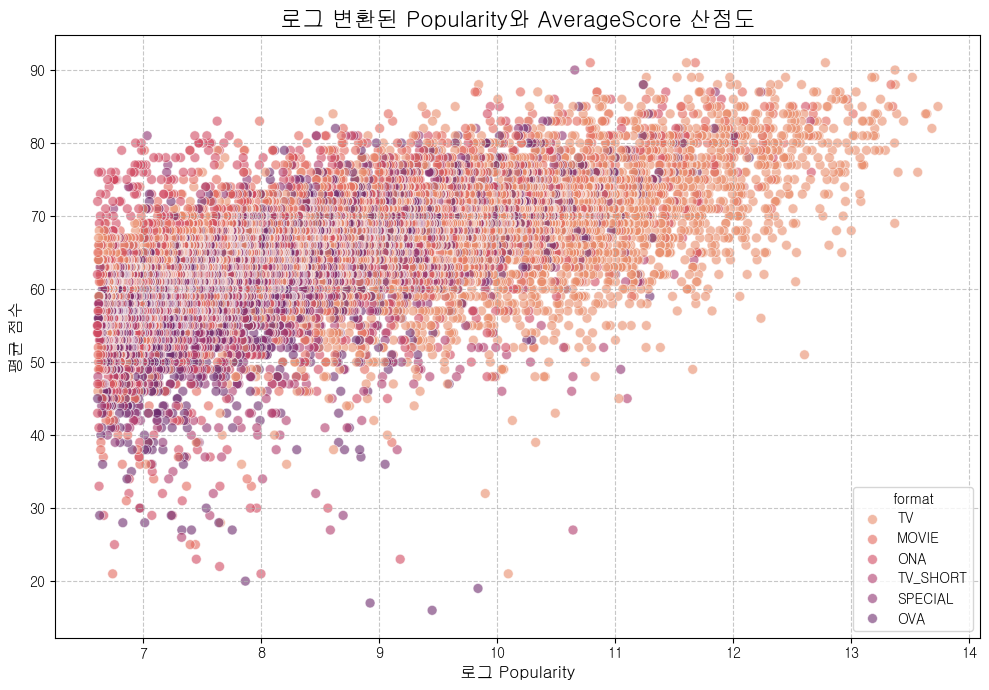

In [64]:
## Log 변환된 인기도를 사용하여 다시 분석
# 0을 피하기 위해 인기도에 1을 더한 후 로그를 취합니다.
plt.figure(figsize=(10, 7))
# popularity의 극심한 왜도 때문에 로그 변환을 적용하여 시각화 (원본 데이터에 임시 적용)
df_temp = df.copy()
df_temp['log_popularity'] = np.log1p(df_temp['popularity']) # log1p는 log(1+x)
# 'rocket' 또는 'mako'와 같은 순차적 팔레트를 사용하여 깊이감 부여
sns.scatterplot(x='log_popularity', y='averageScore', data=df_temp, 
                hue='format', palette='flare', alpha=0.6, s=50) # s는 점 크기
plt.title('로그 변환된 Popularity와 AverageScore 산점도', fontsize=16)
plt.xlabel('로그 Popularity', fontsize=12)
plt.ylabel('평균 점수', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 1. 평균 점수 vs 인기도 (Log 변환산포도)
- 데이터 분석 결과 
   1) 로그 변환을 통해 데이터가 한쪽으로 치우쳐 있는 분포를 펼쳐줌으로써, 
      인기도와 점수간의 관계가 훨씬 명확하게 드러남 
      인기도가 증가할 수록 평균 점수가 전반적으로 상승이 관찰됨 
   2) 원본 데이터의 상관 계수가 0.39 였던 반면 Log 변환 후 0.58로 증가함에 따라
      로그 변환을 통해 인기도와 평균 점수 사이의 관계가 더 잘 드러난 것을 확인 하였으며, 
      인기도가 높은 작품은 평균 점수 또한 비교적 우수한 평가를 받는 경향을 보임
   3) 결론적으로 인기도와 평균 점수는 양의 상관관계가 있다고 판단 됨 

In [65]:
# genres 컬럼 문자열 → 리스트 변환
df_clean['genres'] = df_clean['genres'].fillna('').apply(
    lambda x: x.split(', ') if isinstance(x, str) else x
)

# 각각의 장르를 별도 Row 로 확장(explode)
df_genre_exploded = df_clean.explode('genres')

# 공백/빈 문자열 제거
df_genre_exploded = df_genre_exploded[df_genre_exploded['genres'] != '']



장르 개수 ↔ 평균 점수 상관계수:  0.2719


C:\Users\cjh98\AppData\Local\Temp\ipykernel_8616\1416131157.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genre_group', y='averageScore', data=df_plot, palette='Spectral', width=0.6)


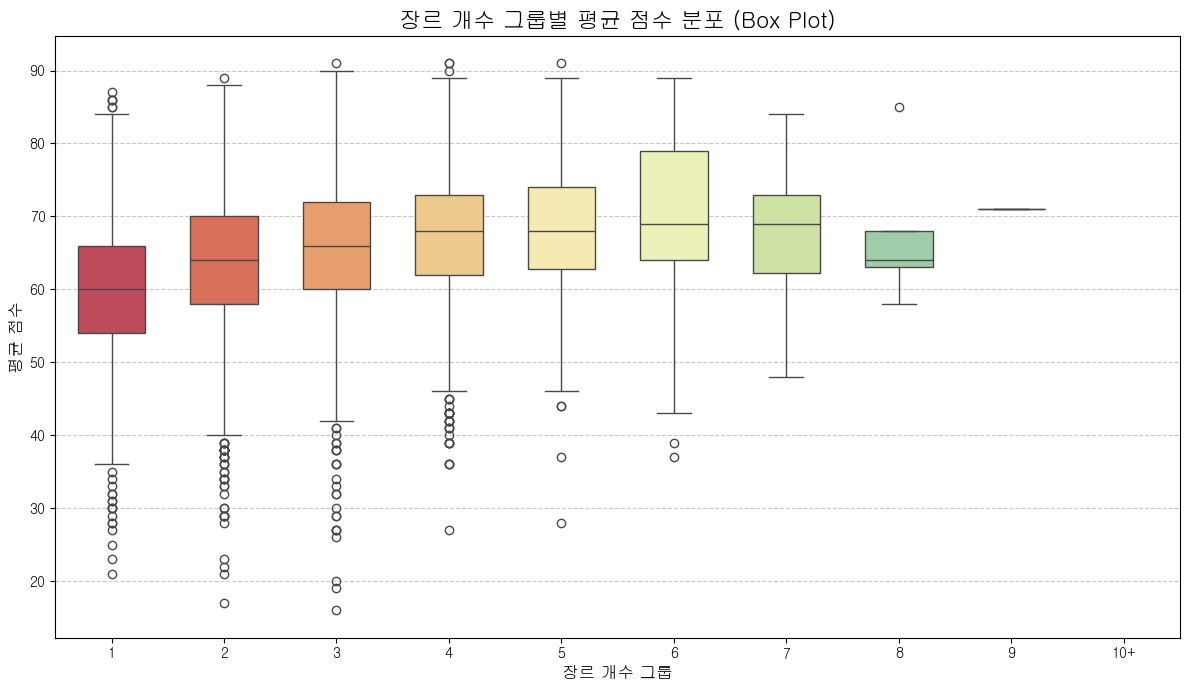

In [66]:
# 장르 개수와 평균 점수의 관계 시각화 (Box Plot)
# 필요한 전처리 수행
# 장르 개수
# genres 컬럼이 문자열 형태('[A, B]')이므로, 이를 리스트로 변환하여 길이를 계산해야 합니다.
try:
    # 문자열 리스트 형태를 Python 리스트로 안전하게 변환
    df['genre_list'] = df['genres'].apply(lambda x: json.loads(x.replace("'", '"')))
    df['genre_count'] = df['genre_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)
except json.JSONDecodeError:
    # 변환 실패 시 (예: 값이 NaN이거나 형식이 완전히 다를 경우) 문자열 파싱으로 대체
    df['genre_count'] = df['genres'].str.strip('[]').str.replace("'", "").str.split(', ').apply(lambda x: len(x) if x and x[0] else 0)


# 상관계수
corr_genre_score = df[['genre_count', 'averageScore']].corr().iloc[0,1]
print("\n장르 개수 ↔ 평균 점수 상관계수: ", round(corr_genre_score, 4))


# 장르 개수별 점수 분포 Box Plot
# 박스 플롯을 보기 좋게 하기 위해 장르 개수가 0인 경우 (극소수)를 제외하고, 10개 이상은 '10+'으로 묶습니다.
df_plot = df[df['genre_count'] > 0].copy()
df_plot['genre_group'] = df_plot['genre_count'].apply(lambda x: '10+' if x >= 10 else str(x))

# 순서 정의
order = [str(i) for i in range(1, 10)] + ['10+']
df_plot['genre_group'] = pd.Categorical(df_plot['genre_group'], categories=order, ordered=True)
df_plot.sort_values('genre_group', inplace=True)

plt.figure(figsize=(12, 7))
# 'Spectral' 팔레트를 사용하여 그룹별 색상 구분
sns.boxplot(x='genre_group', y='averageScore', data=df_plot, palette='Spectral', width=0.6)
plt.title('장르 개수 그룹별 평균 점수 분포 (Box Plot)', fontsize=16)
plt.xlabel('장르 개수 그룹', fontsize=12)
plt.ylabel('평균 점수', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 1. 장르 개수 vs 평균 점수 관계 분석 인기도
- 데이터 분석 결과 
    1) 장르 개수가 1개에서 9개까지 다양하게 분포 하고 있음을 확인
    2) 점들이 고르게 펴져 있어 특정 장르 수가 평균 점수에 절대적인 영향을 주지는 않음
    3) 하지만 회귀선을 보면 장르 개수가 증가할 수록 평균 점수가 완만하게 상승 경향 보임 
    4) 계산된 상관계수는 0.26로, 약한 양의 상관관계가 존재함을 확인 

['id', 'format', 'status', 'start_year', 'start_month', 'start_day', 'end_year', 'end_month', 'end_day', 'airing_days', 'season', 'seasonYear', 'startDate', 'endDate', 'episodes', 'duration', 'averageScore', 'meanScore', 'popularity', 'favourites', 'genres', 'stats', 'title_romaji', 'title_english', 'title_native', 'tag_list', 'studios_list', 'stats_weighted_score', 'stats_drop_rate', 'genre_Action', 'genre_Adventure', 'genre_Comedy', 'genre_Drama', 'genre_Ecchi', 'genre_Fantasy', 'genre_Horror', 'genre_Mahou Shoujo', 'genre_Mecha', 'genre_Music', 'genre_Mystery', 'genre_Psychological', 'genre_Romance', 'genre_Sci-Fi', 'genre_Slice of Life', 'genre_Sports', 'genre_Supernatural', 'genre_Thriller', 'tag_Achronological Order', 'tag_Acting', 'tag_Adoption', 'tag_Advertisement', 'tag_Afterlife', 'tag_Age Gap', 'tag_Age Regression', 'tag_Aliens', 'tag_Alternate Universe', 'tag_Amnesia', 'tag_Anachronism', 'tag_Angels', 'tag_Animals', 'tag_Anthropomorphism', 'tag_Anti-Hero', 'tag_Archery', 't

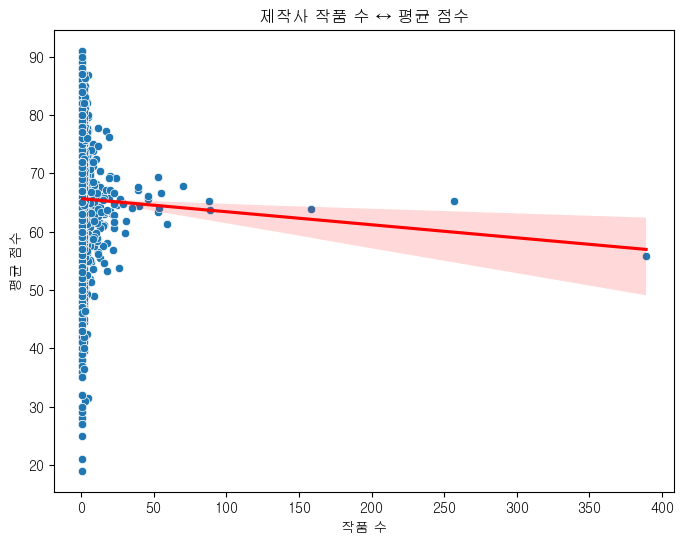

In [67]:
print(df_clean.columns.tolist())


# 스튜디오별 작품 수
studio_counts = df_clean.groupby('studios_list').size().reset_index(name='work_count')

# 스튜디오별 평균 점수
studio_scores = df_clean.groupby('studios_list')['averageScore'].mean().reset_index()

# merge
studio_stats = studio_counts.merge(studio_scores, on='studios_list')

# 상관관계 출력
corr_studio_quality = studio_stats[['work_count', 'averageScore']].corr().iloc[0,1]
print("제작사 규모(작품 수) ↔ 평균 점수 상관계수:", corr_studio_quality)

# 시각화
plt.figure(figsize=(8,6))
sns.scatterplot(data=studio_stats, x='work_count', y='averageScore')
sns.regplot(data=studio_stats, x='work_count', y='averageScore', scatter=False, color='red')
plt.title("제작사 작품 수 ↔ 평균 점수")
plt.xlabel("작품 수")
plt.ylabel("평균 점수")
plt.show()


## 1. 제작사 작품수 와 평균 점수 
- 데이터 분석 결과 
    1) 제작사의 작품수가 증가할 수록 평균 점수는 약하게 감소하는 경향을 보임 
    2) 회귀선 역시 오른쪽으로 갈수록 완만하게 내려가는 형태를 띰 
    3) 제작사는 1편~20편 정도의 소규모 포트폴리오를 가지고 있으며, 구간에는 점수가 폭 넓게 분포
    4) 일부 대형 제작사들은 수백편 단위의 작품을 내고 있음에도 평균 점수는 오히려 중간 수중에 머무는 모습 보임 
    5) 작품수가 증가 할수록 다양한 장르/ 형태/ 제작 환경 등의 변화가 발생 하면서 품질을 일정하게 유지 하는게 
       어려울 것으로 판단 됨

C:\Users\cjh98\AppData\Local\Temp\ipykernel_8616\799545100.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_genres.index, y=top_genres.values, palette='Set2')


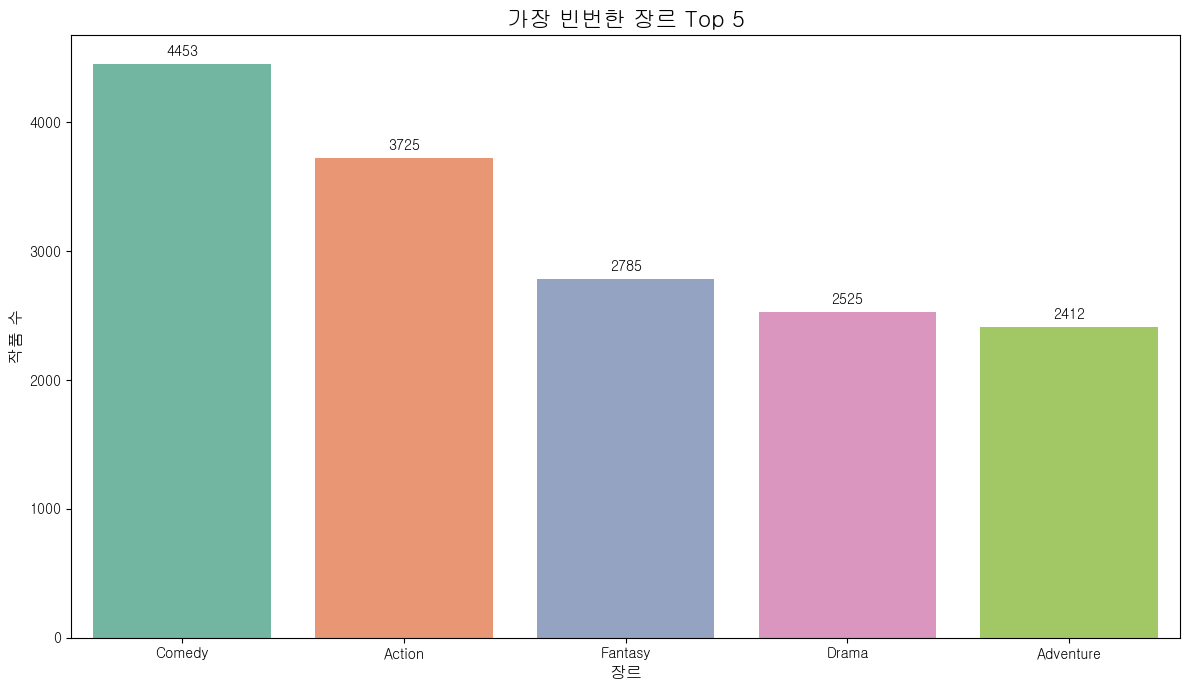

In [68]:
# Top 5 장르 분포 시각화
plt.figure(figsize=(12, 7))
all_genres = df['genres'].str.strip('[]').str.replace("'", "").str.split(', ').explode().str.strip()
top_genres = all_genres.value_counts().head(5)
# 'Set2' 색상 팔레트 사용
ax = sns.barplot(x=top_genres.index, y=top_genres.values, palette='Set2')
plt.title('가장 빈번한 장르 Top 5', fontsize=16)
plt.xlabel('장르', fontsize=12)
plt.ylabel('작품 수', fontsize=12)

# 막대 끝에 수치 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)
plt.tight_layout()
plt.show()

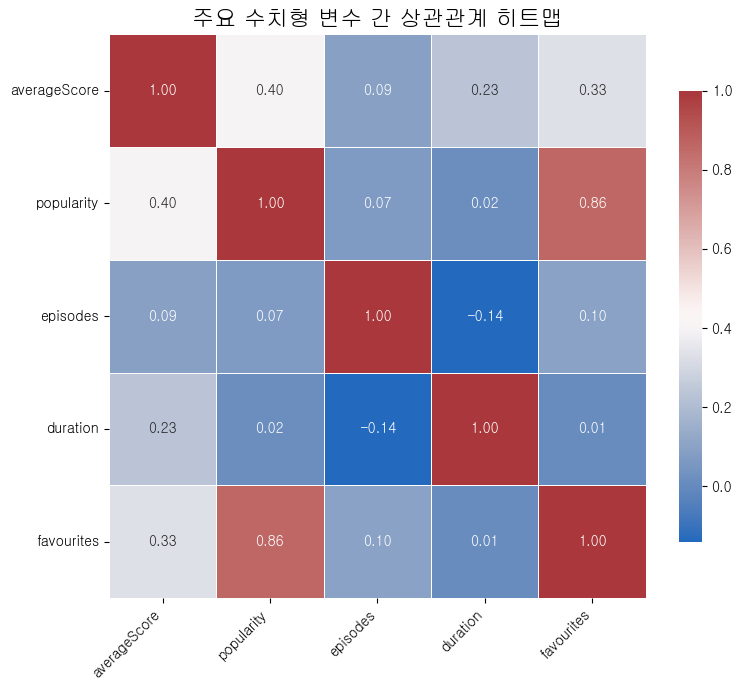

In [69]:
# 상관관계 히트맵 (Heatmap) 추가
plt.figure(figsize=(8, 7))
correlation_cols = ['averageScore', 'popularity', 'episodes', 'duration', 'favourites']
correlation_matrix = df[correlation_cols].corr().round(2)

# 'coolwarm' 또는 'vlag' 팔레트 사용 및 색감 개선
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", # 소수점 둘째 자리까지 표시
            cmap='vlag', # 중앙을 기준으로 양극의 색상을 잘 표현하는 팔레트
            linewidths=.5, # 경계선 추가
            cbar_kws={'shrink': .8}) # 컬러바 크기 조정

plt.title('주요 수치형 변수 간 상관관계 히트맵', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


[7. 제작사 규모와 품질 분석]
제작사 규모(작품 수) ↔ 평균 점수 상관계수: 0.1342

--- 7.2 제작사 규모별 분포 ---
studio_group
Small (하위 25%)          351
Medium (25%~50%)        224
Large (50%~75%)         277
Extra Large (상위 25%)    268
Name: count, dtype: int64


C:\Users\cjh98\AppData\Local\Temp\ipykernel_8616\352743035.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='studio_group', y='averageScore', data=studio_stats,


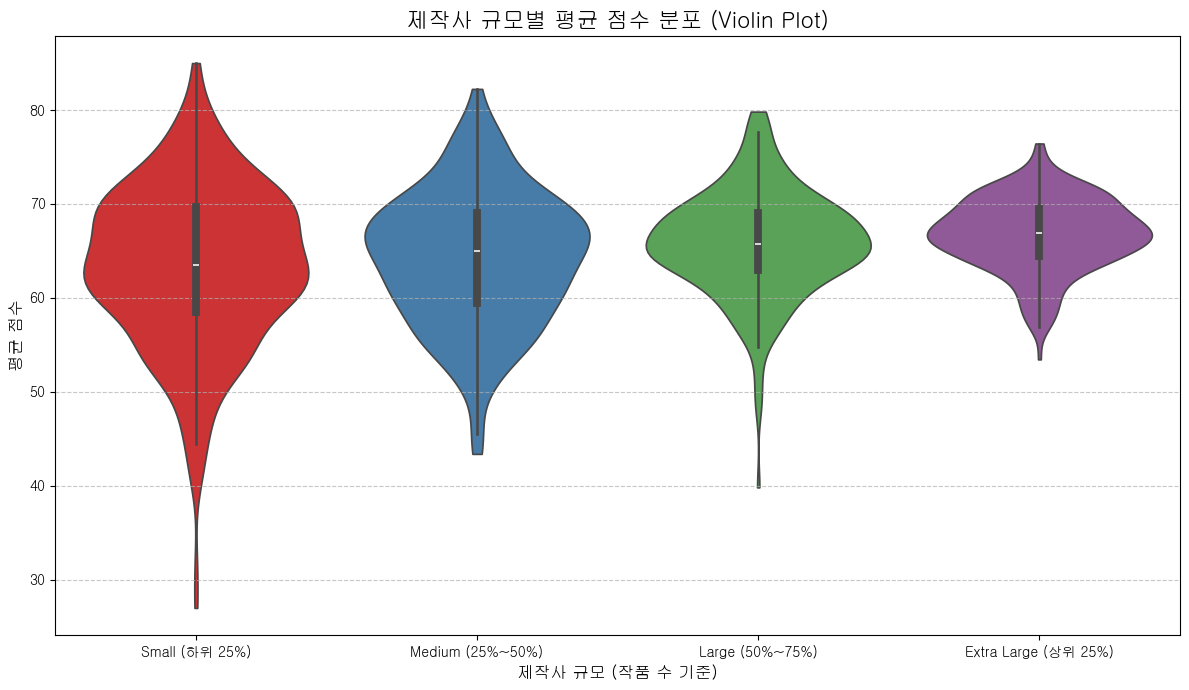

In [70]:
# ===============================================
# 제작사 규모와 품질 분석
# ===============================================

print("\n[7. 제작사 규모와 품질 분석]")

# 데이터 전처리: 스튜디오 리스트 펼치기 및 통계 계산
# studios_list 컬럼이 문자열 형태('[A, B]')이므로, 이를 리스트로 변환하여 펼칩니다.
try:
    # 문자열 리스트 형태를 Python 리스트로 안전하게 변환
    df['studios'] = df['studios_list'].apply(lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x)
except json.JSONDecodeError:
    # 변환 실패 시 문자열 파싱으로 대체
    df['studios'] = df['studios_list'].astype(str).str.strip('[]').str.replace("'", "").str.split(', ').fillna('')

df_studio_exploded = df.explode('studios').rename(columns={'studios': 'studio_name'})

# 공백 또는 NaN 스튜디오 제거
df_studio_exploded = df_studio_exploded[df_studio_exploded['studio_name'].str.strip() != '']
df_studio_exploded.dropna(subset=['studio_name'], inplace=True)


# 스튜디오별 작품 수 및 평균 점수 계산
studio_stats = (
    df_studio_exploded.groupby('studio_name')
    .agg(
        work_count=('id', 'count'),
        averageScore=('averageScore', 'mean')
    )
    .reset_index()
)

# 작품 수 1개인 스튜디오 제거 (분석의 신뢰도를 높이기 위함)
studio_stats = studio_stats[studio_stats['work_count'] > 1].copy()

# 상관관계 출력
corr_studio_quality = studio_stats[['work_count', 'averageScore']].corr().iloc[0,1]
print("제작사 규모(작품 수) ↔ 평균 점수 상관계수:", round(corr_studio_quality, 4))


#제작사 규모 그룹 생성
# 작품 수에 로그 변환을 적용하여 왜곡을 줄이고, 4개의 규모 그룹으로 분류
studio_stats['log_work_count'] = np.log1p(studio_stats['work_count'])
bins = studio_stats['log_work_count'].quantile([0, 0.25, 0.5, 0.75, 1.0]).unique()

# 그룹 라벨 정의
labels = ['Small (하위 25%)', 'Medium (25%~50%)', 'Large (50%~75%)', 'Extra Large (상위 25%)']

# 로그 변환된 작품 수를 기준으로 그룹화
studio_stats['studio_group'] = pd.cut(
    studio_stats['log_work_count'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

print("\n--- 7.2 제작사 규모별 분포 ---")
print(studio_stats['studio_group'].value_counts().sort_index())


# 시각화: 제작사 규모별 평균 점수 분포 (Violin Plot)
plt.figure(figsize=(12, 7))
# 'Set1' 팔레트를 사용하여 그룹별 색상을 명확하게 구분
sns.violinplot(x='studio_group', y='averageScore', data=studio_stats, 
               palette='Set1', inner='box', cut=0) # inner='box'로 박스 플롯 요약 정보 표시
plt.title('제작사 규모별 평균 점수 분포 (Violin Plot)', fontsize=16)
plt.xlabel('제작사 규모 (작품 수 기준)', fontsize=12)
plt.ylabel('평균 점수', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Insights
- 1) TV 포맷이 여전히 시장의 중심축을 이루며, 정규 시즌 기반의 연속적인 콘텐츠 소비 형태가 시장의 주를 이르고 있음
- 2) 평균 점수는 비교적 안정인 수준 이상으로 관리 되고 있으며, 품질 편차가 심하지 않은 산업으로 확인 됨 
- 3) 인기도 측면으로 보면 소수 히트작이 전체 트래픽을 끌어가는 롱테일 구조를 보임 
- 4) 장르 개수 보다는 양질의 콘텐츠로 관객의 감정, 서사 중심의 장르로 접근 하는 것이 효과적일 것으로 보여짐 

# 애니메이션 시장 전망 
1. ONA 비중 급 상승 예상 
- 1) 환경 변화에 따른 ONA(온라인 애니메이션)의 성장 가속화 
- 2) OTT(넷플릭스, 아마존, 디즈니)의 투자 비용 유입
- 3) 짧은 제작 주기 + OTT 최적화로 의 투자 확대를 양질의 콘텐츠를 빠르게 제작 
2. 대형 제작사와 중소 제작사간의 양극화 예상 
- 1) 대형: 많은 작품 제작 --> 품질 일관성 떨어짐 
- 2) 중소: 한두 개 작품 집중 --> 고퀄의 콘텐츠 제작 가능 
3. AI 기반 애니 제작 증가로 작품 수 폭발적 확대 
- 1) 작품수는 폭증하지만, 품질의 양극화도 심화 할 것으로 예상 

# 결론 
- 애니메이션 시장은 소수 작품이 인기를 독점하는 구조 속에서,스토리 중심 장르가 지속적으로 높은 평가를 받고
  제작사의 규모가 품질을 보장하지 않는 양극화 형태로 변화될 것이다. 
  향후 시장은 ONA 중심으로 재편될 가능성이 높으며, AI 제작 등장과 함께 작품 수는 더욱 확장될 전망된다. 